# 10.1 Introduction to stereo vision

Stereo vision is the process of **extracting 3D information** (shape, size and location of objects in space) **from multiple 2D views of a scene**. Stereo vision is used in applications such as driver assistance systems and robot navigation where stereo vision is used to estimate the actual distance or range of objects of interest from the camera.

Humans get 3D information through the **combination of two images**: 

<img src="./images/stereo.jpg" width="400" />

The **disparity** refers to the distance between two corresponding points in the left and right image. Disparity is inversely proportionate to the distance from the camera to te object (depth of the image).

Obviously, we can't infer the depth having only one image, but it does give 3D visual clues with help from **shading, texture, focus, perspective, motion, optical flow** and **occlusion**:$\\[10pt]$

<img src="./images/shading.png" width="330" align="left"/>
<img src="./images/texture.png" width="210" align="rigth"/>
<img src="./images/focus.png" width="300" align="left"/>
<img src="./images/perspective.png" width="330" align="rigth"/>$\\[10pt]$

In this notebook, we will introduce how stereo vision works, and their problems:

- Introduction to scene reconstruction
- Triangulation
- Constraints for correspondence

## Problem context - Scene reconstruction using stereo vision

Having two separated cameras, we can reconstruct a scene (obtain a real size 3D map) knowing the **disparity** of every point and camera intrinsic parameters:

<img src="./images/stereo-reconstruction.png" width="600" />$\\[5pt]$

The research of 3D reconstruction has always been a difficult goal. Using 3D reconstruction we can know the 3D coordinate of any point on the profile. The 3D reconstruction of objects is a generally scientific problem and core technology of a wide variety of fields. Here, we will cover this problem using stereo vision.

From previous notebooks, we know how to transform a depth map into a 3D map using the camera model (also camera calibration is needed).

Our task in this chapter is to understand all the theory behind stereo vision, in order to **generate 3D maps** (even for photos taken with our mobile phone).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
from mpl_toolkits.mplot3d import Axes3D

images_path = './images/'
%matplotlib notebook

### Introduction to scene reconstruction

Having multiple images of a scene, it is possible to **create a 3D map of that scene using stereo vision** techniques. This doesn't require two cameras, but two different views of the scene. For this, we have **different options**:

- **StereoVision system** (the standard one)
    - Two cameras
    - Images taken simultaneously
    - Relative pose of the cameras known
    
<img src="./images/stereovision.jpg" width="400" />

- **Structure-from-Motion** (SFM)
    - One or multiple cameras from different unknown locations, typically with large baseline
    - [Bundle adjustement](https://en.wikipedia.org/wiki/Bundle_adjustment), (refining the 3D coordinates)
    - Cameras can be different (i.e. matrix $K$ not equal)
    
<img src="./images/SFM.png" width="500" />

- **MonoVisual SLAM** (Simultaneous Location And Mapping)
    - One camera
    - Alike SFM but sequentially, small baseline and in real time (e.g. a drone recording a video of a scene while flying around).

<img src="./images/slam.png" width="500" />

The **main problem of stereo vision** is to find the 3D point corresponding to any pixel in the matching images. In other words, the intersection of two lines:

<img src="./images/intersection.png" width="500" />

This seems simple, but some problems appear:

- **Feature matching:** It is needed to detect the features in one image, and detect their correspondences in the other (e.g. Harris + NCC, SIFT, Orb, ...). This have to be precise, because a bad correspondence means noise in the 3D map, we will comment this later in the notebook.$\\[5pt]$

- **Geometric Triangulation:** Compute the depth of the point given the corresponding features. We learn how this is done in the next section.$\\[5pt]$

- Perfect **knowledge of the relative pose** between the cameras, given by the **Epipolar Geometry** (next chapter).$\\[5pt]$ 

## Triangulation

As said before, once we have a pair of matching points, we need to compute the 3D coordinates of the world point. This is done applying the theory learn in **notebook 8.3** (camera model), **assuming an ideal configuration**:

- Identical and parallel cameras
- Right camera along the $X_i$ axis at a distance $b$ (called *baseline*)

It doesn't matter that in practise our cameras doesn't fulfill these condition, because we can **rectify the images** using epipolar geometry (don't worry about this in this moment).$\\[5pt]$

Geometric relation between the two cameras (note that $y_r = y_l$):$\\[5pt]$

$$X_l = RX_r + t \qquad R = I \qquad t = \begin{bmatrix}-b \\ 0 \\ 0 \end{bmatrix}$$

<img src="./images/triangulation1.png" width="500" />

Having a point in the world $\bf{X} = (X,Y,Z)$, we can obtain the projected coordinates in both the left and right image:$\\[5pt]$

<img src="./images/triangulation2.png" width="300" align="left"/>$\\[10pt]$


$$\large{\begin{cases} \frac{x_l}{f} = \frac{X_l}{Z} \\[10pt]  \frac{x_r}{f} = \frac{X_r}{Z} = \frac{X_l - b}{Z} \end{cases}} \normalsize{\xrightarrow{\text{Remove } X_l}  \frac{b}{Z} = \frac{\color{red}{x_l- x_r}}{f} \rightarrow Z = b \frac{f}{\color{red}{d}}} \quad \small{\text{(d = disparity)}}\\[20pt]$$

$$\text{Y axis (the same for both images):} \qquad \frac{y_l}{f} = \frac{y_r}{f} = \frac{Y}{Z} \hspace{6cm}\\[10pt]$$

$$\mathbf{X} = \left[X \quad Y \quad Z\right]^T= \left[ Z\frac{x_l}{f} \quad Z\frac{y_l}{f} \quad Z\right]^T = \left[ b\frac{x_l}{d} \quad b\frac{y_l}{d} \quad b\frac{f}{d} \right]^T = \bf{\frac{b}{d}\left[x_l \quad y_l \quad f\right]^T} \\[30pt]$$

Note that depth $\mathbf{Z}$ in inversally proportional to disparity $\mathbf{d}$. Disparity and coordinates $(x_l,y_l)$ are in meters, measured in the sensor. We have to make a **transformation from camera sensor to image matrix** (notebook 8.3):$\\[5pt]$

<img src="./images/triangulation3.png" width="700"/>$\\[5pt]$

$$\begin{eqnarray} u = -yk_y + u_o \rightarrow y = -(u - u_0)\ / \ k_y \\ v = xk_x + v_o \rightarrow x = (v - v_0)\ / \ k_x \end{eqnarray} \longrightarrow d = x_l - x_r = \frac{(v_l - v_r)}{ k_x} = \frac{d_i}{k_x} \qquad d_i \ \text{means disparity in pixels}\\[15pt]$$

$$\mathbf{X} =  \frac{b}{d}\left[x_l \quad y_l \quad f\right]^T = \frac{bk_x}{d_i}\left[\frac{(v - v_0)}{k_x}\quad -\frac{(u - u_0)}{k_y}\quad f\right]^T = \bf{\frac{b}{d_i}\left[(v - v_0)\quad -\frac{k_x}{k_y}(u - u_0)\quad f\right]^T}\\[30pt]$$

As we can see, the camera intrinsic parameters are necessary for computing the 3D coordinates of a correspondence in two images. **How to know the accuracy of the reconstructed 3D point?**$\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \text{error in the detection of image points} \rightarrow \text{error in disparity} \rightarrow \text{error in depth}\\[5pt]$$

When calculing the depth, the focal lenght and the baseline have fixed values. The only **variable** is the **disparity**.

If we have a error in disparity $\Delta d$, it is possible to calcule how error propagates to Z:$\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \frac{\Delta Z}{\Delta d} = -\frac{bf}{d^2} \longrightarrow \bf{\Delta Z = -\frac{bf}{d}\Delta d = - \frac{Z^2}{fb}\Delta d}\\[5pt]$$

Given a disparity error $\delta d$, the error in Z has a square growth $Z^2$. This implies that for closer objects ($\downarrow Z$), the disparity error is going to be lower ($\downarrow \delta d$). Also, to increase the accuracy of 3D points, the baseline can be increased (separating the cameras). Anyway, this causes more difficulty finding correspondences:$\\[5pt]$

<img src="./images/triangulation4.png" width="900"/>$\\[5pt]$



## Constraints for correspondence

An important decision before starting the job is to decide **which feature we are going to match**. We can match all pixels, only the keypoints, edges, segments, regions, ... Also, we have to decide which descriptor we will use (Harris for corners, SIFT for keypoints, ...).

The precision in the matchings is very important, because a mistake generates a "invented" 3D point:

<img src="./images/correspondence1.png" width="500"/>$\\[5pt]$

We can detect errors in this matching with some constraints from the enviroment:

#### Max-Min disparity allowed

This is an important constraint, as you can easily measure the maximum and minimum disparity. It removes some errors in the matching just using comparisons:

<img src="./images/correspondence2.png" width="500"/>$\\[5pt]$

#### Continuity of the surfaces

In real world, surfaces are smooth, the depth only changes smoothly. This is only violated at occlusion borders (which can be detected using e.g. Canny). There will be a high probability that closeby pixels have similar depth (and disparity).

<img src="./images/correspondence3.png" width="400"/>$\\[5pt]$

#### Uniqueness

Each pixel of the image in the projection of **only one point in 3D**. In other words, a pixel will have only one pixel in correspondence in the other image:

<img src="./images/correspondence4.png" width="400"/>$\\[5pt]$

### **<span style="color:green"><b><i>ASSIGNMENT 1a</i></b></span>**

In this exercise we are going to simulate an ideal stereo system using our phones for reconstructing a scene. As we calibrated our phone camera in the previous chapter, the first step is importing the camera matrix (needed for triangulation).

**What to do?** Use [np.load](https://numpy.org/doc/stable/reference/generated/numpy.load.html) for importing the camera matrix computed in the previous chapter.

*We also provide example images and their corresponding camera matrix if you don't have a camera: `iml.png` (left) and `imr.png` (right), their camera matrices are provided next:*

In [3]:
# Example images camera matrices
intrinsic_l = np.array([[6872.874, 0, 1329.49],[0, 6872.874, 954.485],[0, 0, 1]])
intrinsic_r = np.array([[6872.874, 0, 1623.46],[0, 6872.874, 954.485],[0, 0, 1]])

### **<span style="color:green"><b><i>ASSIGNMENT 1b</i></b></span>**

Now, you will have to **take 2 images** (left and right) of any scene (e.g. place some objects on a table). For simulating the conditions needed for triangulation, try to move in a unique direction without rotating the camera (parallel), also measure and write down the distance you moved the camera between both images (this is our baseline).

This will simulate two rectified images, although **it won't be perfect**. This means that matching pixels won't be in the same vertical coordinate, but a near one.

**What to do?** Load both images. *Remember that you can use the example ones.*

In [4]:
# Load both images
im_l = cv2.imread(images_path + "iml.png")
im_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB)

im_r = cv2.imread(images_path + "imr.png")
im_r = cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB)

# Define baseline
baseline= 174.724

### **<span style="color:green"><b><i>ASSIGNMENT 1c</i></b></span>**

We decided to match only the keypoints! In this way, the 3D reconstruction will only show the keypoints matched. 

**Our task** is to use our favourite **keypoint detector + descriptor** (chapter 4) in order to get a **set of matching point** that will be used for traingulation.

*For big images, we recommend ORB as it is much faster.*

In [5]:
# Get gray images
gray_l = cv2.cvtColor(im_l,cv2.COLOR_RGB2GRAY)
gray_r = cv2.cvtColor(im_r,cv2.COLOR_RGB2GRAY)

# Detect the ORB keypoints using the OpenCV method
# -- create the ORB detector
orb = cv2.ORB_create()

# -- detect ORB keypoints 
kp_l = orb.detect(gray_l,None)
kp_r = orb.detect(gray_r,None)

# -- compute the descriptors with ORB
kp_l, des_l = orb.compute(gray_l, kp_l)
kp_r, des_r = orb.compute(gray_r, kp_r)

# Note: detection and description can be done in just one call

# Match descriptors.
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des_l,des_r)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

### **<span style="color:green"><b><i>ASSIGNMENT 1d</i></b></span>**

In this task, you will have to obtain the 3D coordinates for each keypoint matched. For this, you should apply triangulation theory explained above.

In order to remove errors in matching, we take into account the points matcheds that have not similar vertical coordinate (in ideal configuration matching pixels have same vertical coordinate). Use a threshold (e.g. $|y_l-y_r| > 100$) to only compute the 3D coordinates of those matches.

**What to do?** Show a image drawing the points on it that fulfil previous condition (you can use [cv2.circle](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)). Also, apply triangulation in order to get a list of the 3D coordinates of those points that will be used in next task.

<IPython.core.display.Javascript object>


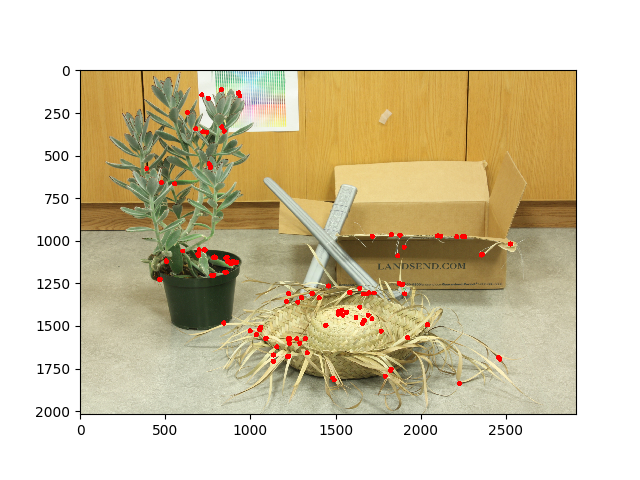

In [6]:
# Define auxiliar data structures
points3D = []
color3D = []
im_points = im_l.copy()
f = intrinsic_l[0,0]
v0 = intrinsic_l[1,2]
u0 = intrinsic_l[0,2]

# For each match
for match in matches:
    point_l = kp_l[match.queryIdx].pt
    point_r = kp_r[match.trainIdx].pt
    # If they are vertically close
    if abs(point_l[0]-point_r[0]) > 100: 
        d = abs(point_l[0]-point_r[0])
        # Draw a circle
        cv2.circle(im_points,(int(point_l[0]),int(point_l[1])),15,[255,0,0],cv2.FILLED)
        # Obtain the color of the pixel
        color3D.append(im_l[int(point_l[1]),int(point_l[0]),:])
        # Obtain the 3D projection using triangulation
        points3D.append((baseline * ((point_l[0]-v0)/d) 
                               ,baseline * ((point_l[1]-u0)/d),
                               (baseline * f) / d))

# Show which matches fulfil the condition
plt.imshow(im_points)

### **<span style="color:green"><b><i>ASSIGNMENT 1e</i></b></span>**

Once 3D coordinates have been computed, the last step is **showing a 3D coloured scatter plot of the scene** using the data obtained in the previous step.

<IPython.core.display.Javascript object>


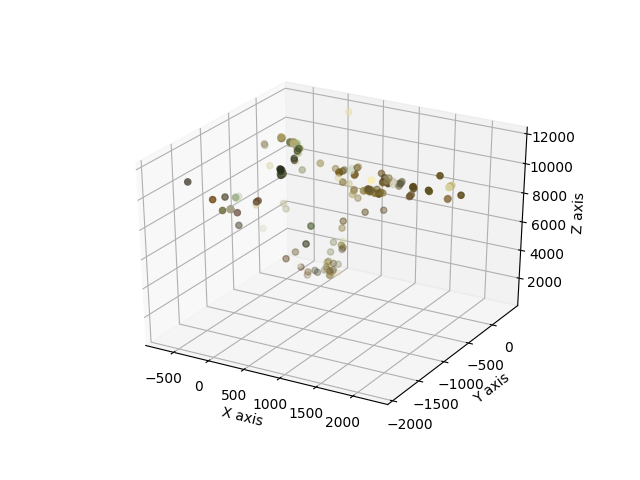

In [7]:
# Transform data to NumPy arrays
points3D = np.array(points3D, dtype=np.int32)
color3D = np.array(color3D, dtype=np.int32)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')

# Name axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Plot points
ax.scatter(points3D[:,0], points3D[:,1], points3D[:,2], c=color3D/255, cmap="rgb")

fig.show()

## Conclusion

Fantastic work! Note that that **3D reconstruction of the scene preserves the real coordinates** regarding the stereo system position. The distance unit used is determined by the camera matrix (focal lenght may be in meters, centimeters, ...).

In this notebook you have learned:

- different stereo reconstruction methods
- triangulation over a pair of rectified images using a ideal StereoVision System
- constraints that can be applied to matching points for detecting errors

In practise, StereoVision Systems images needs to be rectified before applying triangulation, this will be learnt in next notebook.